In [59]:
import pandas as pd

import re
import numpy as np

from pykospacing import spacing
import konlpy
from konlpy.tag import Okt
okt=Okt()

import tensorflow as tf
from tensorflow import keras


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [4]:
data = pd.read_excel('공모전_제공_데이터(1차).xlsx', sheet_name = '학습데이터')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   NO                    1000 non-null   int64  
 1   NO2                   1000 non-null   int64  
 2   발화                    1000 non-null   object 
 3   발화1                   1000 non-null   object 
 4   발화1의 우선순위             1000 non-null   int64  
 5   발화2                   32 non-null     object 
 6   발화2의 우선순위             32 non-null     float64
 7   발화3                   3 non-null      object 
 8   발화3의 우선순위             3 non-null      float64
 9   최종분류(우선순위 가장 높은것 선택)  1000 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 78.2+ KB


In [6]:
data.head(5)

,NO,NO2,발화,발화1,발화1의 우선순위,발화2,발화2의 우선순위,발화3,발화3의 우선순위,최종분류(우선순위 가장 높은것 선택)
0,1,6438,상담직원과 빠른연결했슴좋겠어요,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
1,2,6850,안기다리고. 빨리상담되었음좋겠다,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
2,3,7294,너무 오래기다리고 상담이 늦어져요,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
3,4,9484,상담직원과 통화가 매우 힘들다,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
4,5,10350,상담받으려면오래기다리는게불편함,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템


In [7]:
data_rank = sorted(data['발화1의 우선순위'].unique())

In [8]:
data.isnull().sum()

NO                        0
NO2                       0
발화                        0
발화1                       0
발화1의 우선순위                 0
발화2                     968
발화2의 우선순위               968
발화3                     997
발화3의 우선순위               997
최종분류(우선순위 가장 높은것 선택)      0
dtype: int64

In [9]:
data_2 = data[data['발화2의 우선순위']>0]

In [10]:
data_2

,NO,NO2,발화,발화1,발화1의 우선순위,발화2,발화2의 우선순위,발화3,발화3의 우선순위,최종분류(우선순위 가장 높은것 선택)
8,9,12595,ars상담직원넘많이기다려야하는불편해요,불만>삼성카드>상담/채널,33,불만>고객서비스>상담시스템,5.0,NaN,NaN,불만>고객서비스>상담시스템
24,25,22076,ARS지동응답불필요한안내축소 상담직원과 빠른연결을원합니다 추석연휴 잘 보내세요,불만>삼성카드>상담/채널,33,불만>고객서비스>상담시스템,5.0,칭찬>기타,24.0,불만>고객서비스>상담시스템
96,97,24989,다른 카드사의경우 삼성카드사 보다 통화대기시간이 짧다.,칭찬>기타,24,불만>고객서비스>상담시스템,5.0,NaN,NaN,불만>고객서비스>상담시스템
109,110,25015,신한카드는 상담사 연결시간은 짧아서 좋았습니다 반면 삼성카드는 넘기네요,칭찬>기타,24,불만>고객서비스>상담시스템,5.0,NaN,NaN,불만>고객서비스>상담시스템
121,122,25063,전화연결이 어려울때가 가끔있어요그래도 타사카드보다는 연결이 잘돼요,불만>고객서비스>상담시스템,5,칭찬>삼성카드,23.0,NaN,NaN,불만>고객서비스>상담시스템
136,1262,1588,친절하고 기다리지않게하여주기바람니다,불만>고객서비스>상담원,4,불만>고객서비스>상담시스템,5.0,NaN,NaN,불만>고객서비스>상담원
143,1269,6805,그저 상담은 복사 붙여넣기 시발놈들,불만>고객서비스>상담원,4,불만>기타,42.0,NaN,NaN,불만>고객서비스>상담원
145,1271,7987,전화시신속하고빠르게연결되었으면좋겠습니다.또상담원이좀더친절했으면합니다,불만>고객서비스>상담시스템,5,불만>고객서비스>상담원,4.0,NaN,NaN,불만>고객서비스>상담원
158,1284,11674,다른 카드사 상담 직원은 매우 친절한데 오늘 상담 직원은 최악의 상담사,칭찬>기타,24,불만>고객서비스>상담원,4.0,NaN,NaN,불만>고객서비스>상담원
163,1289,11930,정확하게설명이필요하고 상담원연결이잘안된다,불만>고객서비스>상담원,4,불만>고객서비스>상담시스템,5.0,NaN,NaN,불만>고객서비스>상담원


In [11]:
data_3 = data[data['발화3의 우선순위']>0]

In [12]:
data_3

,NO,NO2,발화,발화1,발화1의 우선순위,발화2,발화2의 우선순위,발화3,발화3의 우선순위,최종분류(우선순위 가장 높은것 선택)
24,25,22076,ARS지동응답불필요한안내축소 상담직원과 빠른연결을원합니다 추석연휴 잘 보내세요,불만>삼성카드>상담/채널,33,불만>고객서비스>상담시스템,5.0,칭찬>기타,24.0,불만>고객서비스>상담시스템
271,1397,17813,타카드사는 상담원들이 기계적인것이아닌 친절하게응대함 삼성카드는 말도빠르고 ...,칭찬>기타,24,불만>고객서비스>상담원,4.0,불만>고객서비스>상담원,4.0,불만>고객서비스>상담원
558,5559,209,부가세신고 시기에 맞게 바로 한번에 연결 메뉴가 있어 너무 편했습니다. 아이디어 낸...,칭찬>삼성카드>생활편의서비스,14,칭찬>고객서비스>상담원,1.0,불만>고객서비스>상담원,4.0,칭찬>고객서비스>상담원


In [13]:
for i in range(0, len(data['발화'])):
    data['발화'][i] = spacing(data['발화'][i])

<ipython-input-13-8c5c0c75d8b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['발화'][i] = spacing(data['발화'][i])


In [14]:
data.head(15)

,NO,NO2,발화,발화1,발화1의 우선순위,발화2,발화2의 우선순위,발화3,발화3의 우선순위,최종분류(우선순위 가장 높은것 선택)
0,1,6438,상담직원과 빠른 연결했슴 좋겠어요,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
1,2,6850,안기다리고. 빨리 상담되었음 좋겠다,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
2,3,7294,너무 오래 기다리고 상담이 늦어져요,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
3,4,9484,상담직원과 통화가 매우 힘들다,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
4,5,10350,상담받으려면 오래 기다리는 게 불편함,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
5,6,11435,상담하려면 많이 기다려야 하는 게 불편합니다.,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
6,7,12111,상담원이 통화 중이라 많이 기다려야 해요,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
7,8,12155,상담직원과의 연결이 빠르게 연결되면 촣겠습니다,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템
8,9,12595,ars상담직원 넘많이 기다려야 하는 불편해요,불만>삼성카드>상담/채널,33,불만>고객서비스>상담시스템,5.0,NaN,NaN,불만>고객서비스>상담시스템
9,10,12745,상담원 통화가 너 믜 힘듬,불만>고객서비스>상담시스템,5,NaN,NaN,NaN,NaN,불만>고객서비스>상담시스템


내용의 최대 길이 :  252
내용의 평균 길이 :  26.682


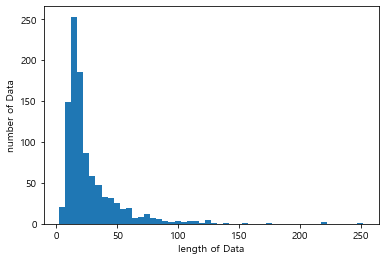

In [15]:
print("내용의 최대 길이 : ", max(len(l) for l in data['발화'])) 
print("내용의 평균 길이 : ", sum(map(len, data['발화']))/ len(data['발화']))
plt.hist([len(s) for s in data['발화']], bins=50) 
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()


In [16]:
data.iloc[8,:].isnull().sum()

2

In [17]:
min(data['발화3의 우선순위'][24],data['발화2의 우선순위'][24],data['발화1의 우선순위'][24])

5.0

In [18]:
labeling_num = []

In [19]:
for i in range(0, len(data)):
    if data.iloc[i,:].isnull().sum() == 0:
        labeling_num.append(int(min(data['발화3의 우선순위'][i],data['발화2의 우선순위'][i],data['발화1의 우선순위'][i])))
    elif data.iloc[i,:].isnull().sum() == 2:
        labeling_num.append(int(min(data['발화2의 우선순위'][i],data['발화1의 우선순위'][i])))
    else:
        labeling_num.append(int(data['발화1의 우선순위'][i]))

In [20]:
data['labeling number'] = labeling_num

In [21]:
data['labeling number'].unique()

array([ 5,  4, 42, 41, 37, 35, 34, 33, 32, 31, 30, 29, 26, 25, 43,  2,  1,
       24, 23, 19, 18, 15, 14, 13, 12, 11,  7], dtype=int64)

In [22]:
data['labeling number'].value_counts()

1     285
4     165
33    135
5     125
24    125
2      35
30     35
25     22
23     15
37     13
43      7
15      6
32      5
42      5
41      4
7       4
29      2
35      2
13      2
11      1
34      1
12      1
14      1
19      1
26      1
31      1
18      1
Name: labeling number, dtype: int64

In [23]:
rank = pd.read_excel('공모전_제공_데이터(1차).xlsx', sheet_name = '우선순위')

In [24]:
rank

,우선순위,의도명(유형)
0,1,칭찬>고객서비스>상담원
1,2,칭찬>고객서비스>상담시스템
2,3,칭찬>고객서비스
3,4,불만>고객서비스>상담원
4,5,불만>고객서비스>상담시스템
5,6,불만>고객서비스
6,7,칭찬>삼성카드>혜택
7,8,칭찬>삼성카드>할부금융상품
8,9,칭찬>삼성카드>커뮤니티서비스
9,10,칭찬>삼성카드>카드이용/결제


In [24]:
data.to_excel('발화내용 띄어쓰기 데이터.xlsx')

In [25]:
def preprocessing(text):
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    return text

In [26]:
for i in range(0, len(data)):
    data['발화'][i] = preprocessing(data['발화'][i])

<ipython-input-26-b09a5eb96d4b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['발화'][i] = preprocessing(data['발화'][i])


In [28]:
data = data.rename(columns={'최종분류(우선순위 가장 높은것 선택)':'최종분류'})

In [30]:
label = []
for i in range(0, len(data)):
    if data['최종분류'][i][0:2] == '불만':
        label.append(-1)
    elif data['최종분류'][i][0:2] == '중립':
        label.append(0)
    elif data['최종분류'][i][0:2] == '칭찬':
        label.append(1)

In [31]:
data['label'] = label

In [33]:
data.loc[:, '최종분류':'label']

,최종분류,labeling number,label
0,불만>고객서비스>상담시스템,5,-1
1,불만>고객서비스>상담시스템,5,-1
2,불만>고객서비스>상담시스템,5,-1
3,불만>고객서비스>상담시스템,5,-1
4,불만>고객서비스>상담시스템,5,-1
...,...,...,...
995,칭찬>삼성카드>카드상품,11,1
996,칭찬>삼성카드>혜택,7,1
997,칭찬>삼성카드>혜택,7,1
998,칭찬>삼성카드>혜택,7,1


In [49]:
contents = []
labels = []
for i in range(50,950):
    contents.append(data['발화'][i])
    labels.append(data['label'][i])

In [50]:
train_data = pd.DataFrame({"content":contents, "label":labels})

In [51]:
contents = []
labels = []
for i in range(0,50):
    contents.append(data['발화'][i])
    labels.append(data['label'][i])
for i in range(950,1000):
    contents.append(data['발화'][i])
    labels.append(data['label'][i])

In [52]:
test_data = pd.DataFrame({"content":contents, "label":labels})

In [53]:
train_data

,content,label
0,상담원 연결대기 시간이 길지 않으면 합니다,-1
1,상담원 통화 대기시간이 너무 길다,-1
2,상담원과 통화하 대기시간이 너무 길어요,-1
3,상담원과의 통화 대기시간이 짧앗으면 좋겟 음,-1
4,상담원과의 통화 대기 시간이 너무 길다,-1
...,...,...
895,국민카드 발급 상담 시 연회비 및 기타 사항들을 꼼꼼한 비교 설명으로 카드 발급 선...,1
896,SKT가 상담할 때 더 상냥하게 느껴져요 목소리에서도 미소가 느껴져요,1
897,타 회사 전화 상담 시에 알아들을 수 있을 때까지 설명해줌으로 해서 너무 고마움을 ...,1
898,신한카드 가 좀 더 친절함,1


In [54]:
test_data

,content,label
0,상담직원과 빠른 연결했슴 좋겠어요,-1
1,안기다리고 빨리 상담되었음 좋겠다,-1
2,너무 오래 기다리고 상담이 늦어져요,-1
3,상담직원과 통화가 매우 힘들다,-1
4,상담받으려면 오래 기다리는 게 불편함,-1
...,...,...
95,카드분실된 지 1분 만에 카드를 통해서 연락받아 바로 찾았어요 잃어버린 지도 몰랐는...,1
96,수시로 6개월 무이자 할부와 링크 혜택이 다른 카드와 구별되는 기능이 편리함,1
97,무이자 할부 자주 많이 주셔서 감사합니다,1
98,무이자 혜택 만족긴 할부 만족 잘 쓰고 있습니다,1


In [60]:
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']


X_train = []
for sentence in train_data['content']:
    temp_X = [] 
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
    X_train.append(temp_X)


X_test = [] 
for sentence in test_data['content']: 
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화 
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거 
    X_test.append(temp_X)


In [61]:
from keras.preprocessing.text import Tokenizer
max_words = 35000 
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

내용의 최대 길이 :  76
내용의 평균 길이 :  7.857777777777778


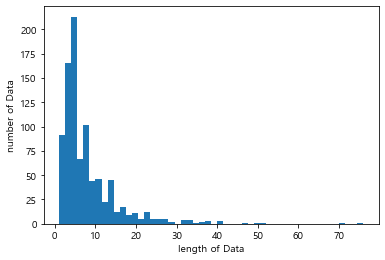

In [62]:
print("내용의 최대 길이 : ", max(len(l) for l in X_train)) 
print("내용의 평균 길이 : ", sum(map(len, X_train))/ len(X_train))
plt.hist([len(s) for s in X_train], bins=50) 
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()


내용의 최대 길이 :  56
내용의 평균 길이 :  8.17


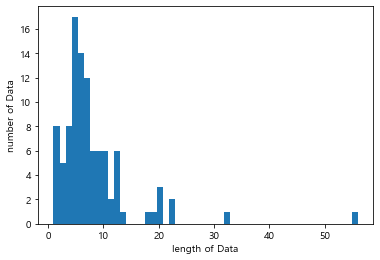

In [63]:
print("내용의 최대 길이 : ", max(len(l) for l in X_test))
print("내용의 평균 길이 : ", sum(map(len, X_test))/ len(X_test))
plt.hist([len(s) for s in X_test], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()


In [64]:
import numpy as np 
y_train = []
y_test = []
for i in range(len(train_data['label'])):
    if train_data['label'].iloc[i] == 1:
        y_train.append([0, 0, 1]) 
    elif train_data['label'].iloc[i] == 0:
        y_train.append([0, 1, 0]) 
    elif train_data['label'].iloc[i] == -1: 
        y_train.append([1, 0, 0])
        
for i in range(len(test_data['label'])): 
    if test_data['label'].iloc[i] == 1: 
        y_test.append([0, 0, 1]) 
    elif test_data['label'].iloc[i] == 0: 
        y_test.append([0, 1, 0]) 
    elif test_data['label'].iloc[i] == -1:
        y_test.append([1, 0, 0]) 
        
        
y_train = np.array(y_train) 
y_test = np.array(y_test)


In [65]:
y_train

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [66]:
y_test

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0,

In [67]:
from keras.layers import Embedding, Dense, LSTM 
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
max_len = 15 
X_train = pad_sequences(X_train, maxlen=max_len) 
X_test = pad_sequences(X_test, maxlen=max_len)

In [79]:
model = Sequential() 
model.add(Embedding(max_words, 100))
model.add(LSTM(128)) 
model.add(Dense(3, activation='softmax')) 


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_split = 0.1)


Epoch 1/10
81/81 [==============================] - 5s 42ms/step - loss: 0.7418 - accuracy: 0.6022 - val_loss: 1.9272 - val_accuracy: 0.1111
Epoch 2/10
81/81 [==============================] - 3s 33ms/step - loss: 0.2366 - accuracy: 0.9279 - val_loss: 1.9017 - val_accuracy: 0.2778
Epoch 3/10
81/81 [==============================] - 3s 33ms/step - loss: 0.1060 - accuracy: 0.9690 - val_loss: 2.9772 - val_accuracy: 0.1556
Epoch 4/10
81/81 [==============================] - 3s 32ms/step - loss: 0.0624 - accuracy: 0.9835 - val_loss: 4.8401 - val_accuracy: 0.1556
Epoch 5/10
81/81 [==============================] - 3s 31ms/step - loss: 0.0350 - accuracy: 0.9915 - val_loss: 6.1026 - val_accuracy: 0.2000
Epoch 6/10
81/81 [==============================] - 3s 42ms/step - loss: 0.0567 - accuracy: 0.9782 - val_loss: 4.5240 - val_accuracy: 0.2111
Epoch 7/10
81/81 [==============================] - 4s 44ms/step - loss: 0.0330 - accuracy: 0.9881 - val_loss: 4.8169 - val_accuracy: 0.2444
Epoch 8/10
81

In [80]:
print(" \n 테스트 정확도 : {:.2f}%".format(model.evaluate(X_test, y_test)[1] * 100))

4/4 [==============================] - 1s 5ms/step - loss: 3.2643 - accuracy: 0.5600
 
 테스트 정확도 : 56.00%


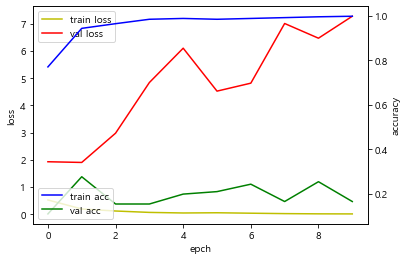

In [81]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [82]:
predict = model.predict(X_test)

In [83]:
import numpy as np 
predict_labels = np.argmax(predict, axis=1)
original_labels = np.argmax(y_test, axis=1)

In [84]:
for i in range(30): 
    print("기사내용 : ", test_data['content'].iloc[i], "/\t 원래 라벨 : ", original_labels[i], "/\t예측한 라벨 : ", predict_labels[i])


기사내용 :  상담직원과 빠른 연결했슴 좋겠어요 /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사내용 :  안기다리고  빨리 상담되었음 좋겠다 /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사내용 :  너무 오래 기다리고 상담이 늦어져요 /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사내용 :  상담직원과 통화가 매우 힘들다 /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사내용 :  상담받으려면 오래 기다리는 게 불편함 /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사내용 :  상담하려면 많이 기다려야 하는 게 불편합니다  /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사내용 :  상담원이 통화 중이라 많이 기다려야 해요 /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사내용 :  상담직원과의 연결이 빠르게 연결되면 촣겠습니다 /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사내용 :  ars상담직원 넘많이 기다려야 하는 불편해요 /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사내용 :  상담원 통화가 너 믜 힘듬 /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사내용 :  상담원과의 연결이 빨리 되었으면 감사 힘니다 /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사내용 :  상담원이 영결이 많이 힘이듬 /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사내용 :  5번 질문에 대한 답변은 상담직원 연결되기까지 기다리는 것 말곤 없는 듯 /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사내용 :  상담을 하려면 좀 많이 기다려야 상담사분이 나오셔서 그게 좀 불편하네요 /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사내용 :  Talk 상담이 다시 생겼으면   /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사내용 :  상담하려 하는 기다리는 시간 너무 길다 /	 원래 라벨 :  0 /	예측한 라벨 :  0
기사내용 :  상담직원과 빠른 속도로 연결이 되길 원합니다 /	 원래 라벨 :  0 /	

In [85]:
labels_res = pd.DataFrame()

labels_res['original'] = pd.Series(original_labels)
labels_res['predict'] = pd.Series(predict_labels)
print(labels_res['original'].value_counts())
print(labels_res['predict'].value_counts())

2    50
0    50
Name: original, dtype: int64
0    83
2    16
1     1
Name: predict, dtype: int64
